In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
file_location = "D:\\data4class.csv"
data = pd.read_csv(file_location)

In [3]:
data.head()

,trade_dt,Open,Close,High,Low,Volume
0,2011-01-04,9987.843667,9988.433667,9988.994000,9974.463333,61203042.0
1,2011-01-05,9987.425000,10013.965670,10014.655000,9987.425000,57010514.0
2,2011-01-06,10009.830330,10011.662670,10015.663670,10005.940330,45459917.5
3,2011-01-07,10009.235000,9987.255667,10011.939670,9978.643667,59544733.0
4,2011-01-10,9982.935667,9949.304667,9982.935667,9943.223000,48316134.0


In [4]:
data.iloc[0:4,2]

0     9988.433667
1    10013.965670
2    10011.662670
3     9987.255667
Name: Close, dtype: float64

In [8]:
#MA计算，加入到原始列表中
data['MA5']=data.Close.rolling(5).mean()
data['MA10']=data.Close.rolling(10).mean()
data['MA30']=data.Close.rolling(10).mean()

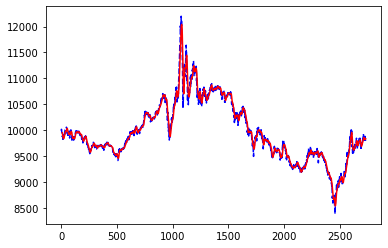

In [14]:
plt.plot(data.index, data['Close'], 'b--',label="收盘价")
plt.plot(data.index, data['MA30'], 'r-',label="30日均线")
#plt.xticks(data['Close'],data['trade_dt'])

In [9]:
data.head()

,trade_dt,Open,Close,High,Low,Volume,MA5,MA10,MA30
0,2011-01-04,9987.843667,9988.433667,9988.994000,9974.463333,61203042.0,NaN,NaN,NaN
1,2011-01-05,9987.425000,10013.965670,10014.655000,9987.425000,57010514.0,NaN,NaN,NaN
2,2011-01-06,10009.830330,10011.662670,10015.663670,10005.940330,45459917.5,NaN,NaN,NaN
3,2011-01-07,10009.235000,9987.255667,10011.939670,9978.643667,59544733.0,NaN,NaN,NaN
4,2011-01-10,9982.935667,9949.304667,9982.935667,9943.223000,48316134.0,9990.124468,NaN,NaN


In [27]:
#加上止盈和止损的Granville
buy_price = None
sell_price = None
trading = False
long = 0
short = 0

#初始资金为100000000
available_cash = [100000000]
available_borrowing = [100000000]
market_value = []
s_market_value = []
#初始持仓为0
position = []
s_position = []
rate_list = []

for i in range(30,len(data)):

    #多头开仓
    if trading==False and long == 0:#做多开仓
        #1-长期均线（30天）在拐点，i-1天短线5上穿长线10
        if data.iloc[i].MA30>data.iloc[i-1].MA30 and data.iloc[i-1].MA30<data.iloc[i-2].MA30 and data.iloc[i-1].MA5 > data.iloc[i-1].MA10 and data.iloc[i-2].MA10 < data.iloc[i-2].MA5: 
            trading = True
            long = 1
            num = int(available_cash[-1] / (100*data.iloc[i].Close))*100
            print('多头开仓','在',data.iloc[i].trade_dt,'以',data.iloc[i].Close,'价格','买入',num,'股')
            available_cash.append(available_cash[-1] - num*data.iloc[i].Close)
            market_value.append(num*data.iloc[i].Close)
            position.append(num)
            #print(position)

     ####空头开仓：借股票还股票                    
    if trading == False and short == 0:
        #做多情况下平仓，长期均线（30天）连续两天下降，i-1天短线5下穿长线10，i天短线5下穿长线10（或者，i-1天短线10下穿长线30）
        if data.iloc[i].MA30<data.iloc[i-1].MA30 and data.iloc[i-1].MA30<data.iloc[i-2].MA30 and data.iloc[i-1].MA5<data.iloc[i-1].MA10 and data.iloc[i-2].MA10>data.iloc[i-2].MA5:      
            num = int(available_borrowing[-1] / (100*data.iloc[i].Close))*100
            print('空头开仓','在',data.iloc[i].trade_dt,'以',data.iloc[i].Close,'价格','卖出',num,'股')
            #print(data.index[i],data.iloc[i].close,'卖出',position[i-1],file=f)
            available_borrowing.append(available_borrowing[-1] - num*data.iloc[i].Close)
            s_market_value.append(-num*data.iloc[i].Close)
            s_position.append(-num)
            trading = True
            short = 1
            
    ####空头平仓
    if trading==True and short == 1:
        #空头止盈平仓
        if (data.iloc[i].Close-data.iloc[0].Close)/data.iloc[0].Close<-0.10:
            print('空头止盈平仓','在',data.iloc[i].trade_dt,'以',data.iloc[i].Close,'价格','买入',s_position[-1],'股')
            available_borrowing.append(available_borrowing[-1] - s_position[-1]*data.iloc[i].Close)
            s_market_value.append(0)
            s_position.append(0)
            trading = False
            short = 0
        else:
            trading = True
            if trading==True and short == 1:
                if (data.iloc[i].Close-data.iloc[0].Close)/data.iloc[0].Close>0.1:
                    print('空头止损平仓','在',data.iloc[i].trade_dt,'以',data.iloc[i].Close,'价格','买入',s_position[-1],'股')
                    #print(data.index[i],data.iloc[i].close,'卖出',position[i-1],file=f)
                    available_borrowing.append(available_borrowing[-1] - s_position[-1]*data.iloc[i].Close)
                    s_market_value.append(0)
                    s_position.append(0)
                    trading = False
                    short = 0
                else:
                    trading = True
                    if trading==True and short == 1:
                        if data.iloc[i].MA30>data.iloc[i-1].MA30 and data.iloc[i-1].MA30<data.iloc[i-2].MA30 and data.iloc[i-1].MA5 > data.iloc[i-1].MA10 and data.iloc[i-2].MA10 < data.iloc[i-2].MA5: 
                            print('空头平仓','在',data.iloc[i].trade_dt,'以',data.iloc[i].Close,'价格','买入',s_position[-1],'股')
                            #print(data.index[i],data.iloc[i].close,'卖出',position[i-1],file=f)
                            available_borrowing.append(available_borrowing[-1] - s_position[-1]*data.iloc[i].Close)
                            s_market_value.append(0)
                            s_position.append(0)
                            trading = False
                            short = 0

    #多头平仓
    if trading==True and long == 1:
        #做多情况下平仓，长期均线（30天）连续两天下降，i-1天短线5下穿长线10，i天长线10上穿短线5（或者改为i-1天短线10下穿长线30）
        #止盈平仓
        if (data.iloc[i].Close-data.iloc[0].Close)/data.iloc[0].Close>0.15:
            print('多头止盈平仓','在',data.iloc[i].trade_dt,'以',data.iloc[i].Close,'价格','卖出',position[-1],'股')
            #print(data.index[i],data.iloc[i].close,'卖出',position[i-1],file=f)
            available_cash.append(available_cash[-1] + position[-1]*data.iloc[i].Close)
            market_value.append(0)
            position.append(0)
            trading = False
            long = 0
        else:
            trading = True
            if trading==True and long == 1:
                if (data.iloc[i].Close-data.iloc[0].Close)/data.iloc[0].Close<-0.05:
                    print('多头止损平仓','在',data.iloc[i].trade_dt,'以',data.iloc[i].Close,'价格','卖出',position[-1],'股')
                    #print(data.index[i],data.iloc[i].close,'卖出',position[i-1],file=f)
                    available_cash.append(available_cash[-1] + position[-1]*data.iloc[i].Close)
                    market_value.append(0)
                    position.append(0)
                    trading = False
                    long = 0
                else:
                    trading = True
                    if trading==True and long == 1:
                        if data.iloc[i].MA30<data.iloc[i-1].MA30 and data.iloc[i-1].MA30<data.iloc[i-2].MA30 and data.iloc[i-1].MA5<data.iloc[i-1].MA10 and data.iloc[i-2].MA10>data.iloc[i-2].MA5:
                            print('多头平仓','在',data.iloc[i].trade_dt,'以',data.iloc[i].Close,'价格','卖出',position[-1],'股')
                            #print(data.index[i],data.iloc[i].close,'卖出',position[i-1],file=f)
                            available_cash.append(available_cash[-1] + position[-1]*data.iloc[i].Close)
                            market_value.append(0)
                            position.append(0)
                            trading = False
                            long = 0
   
    
    
'''
np.array(available_cash)
np.array(market_value)
np.array(available_borrowing)
np.array(s_market_value)
'''
'''


空头开仓 在 2011-03-09 以 9952.504333 价格 卖出 10000 股
空头平仓 在 2011-06-13 以 9865.960333 价格 买入 -10000 股
空头开仓 在 2011-06-22 以 9809.347667 价格 卖出 10100 股
空头平仓 在 2011-07-01 以 9857.202667 价格 买入 -10100 股
空头开仓 在 2011-08-01 以 9955.704 价格 卖出 10000 股
空头平仓 在 2011-08-22 以 9968.636 价格 买入 -10000 股
多头开仓 在 2011-08-29 以 9977.746667 价格 买入 10000 股
多头平仓 在 2011-09-02 以 9929.914333 价格 卖出 10000 股
空头开仓 在 2011-09-05 以 9918.679333 价格 卖出 10000 股
空头平仓 在 2011-09-26 以 9927.148 价格 买入 -10000 股
空头开仓 在 2011-09-30 以 9826.984667 价格 卖出 10100 股
空头平仓 在 2011-11-03 以 9824.561333 价格 买入 -10100 股
空头开仓 在 2011-11-30 以 9862.225 价格 卖出 10100 股
空头平仓 在 2012-04-16 以 9720.060333 价格 买入 -10100 股
空头开仓 在 2012-04-26 以 9672.315333 价格 卖出 10100 股
空头平仓 在 2012-09-18 以 9751.384 价格 买入 -10100 股
空头开仓 在 2012-09-21 以 9733.860667 价格 卖出 10100 股
空头平仓 在 2012-10-18 以 9697.596667 价格 买入 -10100 股
多头开仓 在 2012-10-26 以 9698.073333 价格 买入 10200 股
多头平仓 在 2012-11-07 以 9689.039333 价格 卖出 10200 股
空头开仓 在 2012-11-08 以 9678.090667 价格 卖出 10200 股
空头平仓 在 2013-01-15 以 9541.715667 价格 买入 -10

'\nnp.array(available_cash)\nnp.array(market_value)\nnp.array(available_borrowing)\nnp.array(s_market_value)\n'

In [28]:
np.array(available_cash)[-1]

103891372.59706661

In [29]:
np.array(available_cash)[-1]/100000000-1

0.038913725970666

In [30]:
(100000000-np.array(available_borrowing)[-1])/100000000

0.0881348302260019

In [31]:
np.array(available_borrowing)

array([1.00000000e+08, 4.74956670e+05, 9.91345600e+07, 6.01485633e+04,
       9.96178955e+07, 6.08555000e+04, 9.97472155e+07, 5.60422170e+05,
       9.98319022e+07, 5.79357033e+05, 9.98074265e+07, 1.98953997e+05,
       9.83715634e+07, 6.81178497e+05, 9.91701569e+07, 8.58164160e+05,
       9.88038905e+07, 8.73656932e+04, 9.74128655e+07, 6.64675493e+05,
       9.86784917e+07, 7.16998097e+05, 9.90763801e+07, 9.50493997e+05,
       9.94634899e+07, 5.81603503e+05, 1.02727860e+08, 2.16166536e+05,
       1.02222303e+08, 3.00136536e+05, 1.06939780e+08, 5.58247336e+05,
       1.07728236e+08, 2.82601836e+05, 1.02067748e+08, 8.66480504e+05,
       1.03410100e+08, 1.45001680e+05, 1.03410100e+08, 5.88706754e+05,
       1.03410100e+08, 5.61924001e+05, 1.03410100e+08, 5.66757284e+05,
       1.03410100e+08, 4.43370344e+05, 1.03410100e+08, 4.56381342e+05,
       1.04001324e+08, 9.61778840e+05, 1.04001324e+08, 2.95385396e+05,
       1.04001324e+08, 8.79168902e+05, 1.04812712e+08, 5.74732122e+05,
      

In [32]:
np.array(market_value)

array([9.97774667e+07, 0.00000000e+00, 9.89203480e+07, 0.00000000e+00,
       9.85450167e+07, 0.00000000e+00, 9.88654224e+07, 0.00000000e+00,
       1.07222878e+08, 0.00000000e+00, 1.06476486e+08, 0.00000000e+00,
       1.06382171e+08, 0.00000000e+00, 1.03909149e+08, 0.00000000e+00,
       1.05675280e+08, 0.00000000e+00, 1.05778741e+08, 0.00000000e+00,
       1.06531903e+08, 0.00000000e+00, 1.06719224e+08, 0.00000000e+00,
       1.06495774e+08, 0.00000000e+00, 1.06069859e+08, 0.00000000e+00,
       1.05217246e+08, 0.00000000e+00, 1.05251787e+08, 0.00000000e+00,
       1.05021424e+08, 0.00000000e+00, 1.05426779e+08, 0.00000000e+00,
       1.04887605e+08, 0.00000000e+00])

In [33]:
np.array(s_market_value)

array([-9.95250433e+07,  0.00000000e+00, -9.90744114e+07,  0.00000000e+00,
       -9.95570400e+07,  0.00000000e+00, -9.91867933e+07,  0.00000000e+00,
       -9.92525451e+07,  0.00000000e+00, -9.96084725e+07,  0.00000000e+00,
       -9.76903849e+07,  0.00000000e+00, -9.83119927e+07,  0.00000000e+00,
       -9.87165248e+07,  0.00000000e+00, -9.67481900e+07,  0.00000000e+00,
       -9.79614936e+07,  0.00000000e+00, -9.81258861e+07,  0.00000000e+00,
       -9.88818864e+07,  0.00000000e+00, -1.02511693e+08,  0.00000000e+00,
       -1.01922167e+08,  0.00000000e+00, -1.06381532e+08,  0.00000000e+00,
       -1.07445634e+08,  0.00000000e+00, -1.01201267e+08,  0.00000000e+00,
       -1.03265098e+08,  0.00000000e+00, -1.02821393e+08,  0.00000000e+00,
       -1.02848176e+08,  0.00000000e+00, -1.02843342e+08,  0.00000000e+00,
       -1.02966729e+08,  0.00000000e+00, -1.02953718e+08,  0.00000000e+00,
       -1.03039546e+08,  0.00000000e+00, -1.03705939e+08,  0.00000000e+00,
       -1.03122155e+08,  